In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

In [ ]:
# =========【Configuration and parameters】=========
DATA_FOLDER = "/content/drive/MyDrive/Random/Hiroshima/ABC2025/Test"

# 训练 ID
USER_IDS = ["T1N01", "T1F01", "T1S01", "T1S02"]  # 这里替换成你需要训练的ID
# 测试 ID
TEST_IDS = ["T1N02", "T1F02"]  # 这里替换成你需要测试的ID

FS = 33  # Sampling rate

# Action label encoding mapping
action_mapping = {
    "Explanation to patient": 0,
    "Confirm necessary items": 1,
    "Disinfect hands": 2,
    "Wearing gloves": 3,
    "Prepare the nutrition solution": 4,
    "Check the gastrostomy site": 5,
    "Open the gastrostomy cap": 6,
    "Inject lukewarm water": 7,
    "Connect the nutrition tube": 8,
    "Adjust the infusion rate": 9,
    "Removal of gloves": 10,
    "Prepare lukewarm water": 11,
    "Close the clamp": 12,
    "Disconnect the nutrition tube": 13,
    "Close the gastrostomy cap": 14,
    "Clean up used items": 15,
    "Others": 16
}

# =========【Load and clean data】=========
def load_data(user_ids, data_folder=DATA_FOLDER, fs=FS):
    all_kp_data = []
    all_ann_data = []

    for user_id in user_ids:
        keypoint_csv = f"{data_folder}/Body_KeyPoint_CSV/Front_{user_id}.csv"
        ann_csv = f"{data_folder}/Annotation_CSV/Front_{user_id}.csv"

        # 读取并去掉多余列（如Unnamed等）
        kp_df_raw = pd.read_csv(keypoint_csv)
        ann_df_raw = pd.read_csv(ann_csv)
        kp_df = kp_df_raw.loc[:, ~kp_df_raw.columns.str.contains('^Unnamed')]
        ann_df = ann_df_raw.loc[:, ~ann_df_raw.columns.str.contains('^Unnamed')]

        # 根据需要清理一些不需要的关节点，如膝盖、脚踝等
        kp_df = kp_df.loc[:, ~kp_df.columns.str.contains('Frame|conf|left_knee|right_knee|left_ankle|right_ankle', regex=True)]

        all_kp_data.append(kp_df)
        all_ann_data.append(ann_df)
    return all_kp_data, all_ann_data

print("Loading training data...")
all_kp_data, all_ann_data = load_data(USER_IDS)
print("Loading testing data...")
test_all_kp_data, test_all_ann_data = load_data(TEST_IDS)
print("Data loaded successfully!")

Loading training data...
Loading testing data...
Data loaded successfully!


In [ ]:
SMOOTH_LEN = 3  # Smoothing length, in seconds

def smooth_kp(kp_col, fs=FS, smooth_len=SMOOTH_LEN):
    zero_idx = np.flatnonzero(kp_col == 0)
    # 将连续的0分段
    split_idx = np.split(zero_idx, np.flatnonzero(np.diff(zero_idx) > 1) + 1)
    for each_split_idx in split_idx:
        # 如果是开头或结尾或长度过长，则跳过
        if len(each_split_idx) == 0 or each_split_idx[0] == 0 or each_split_idx[-1] == (len(kp_col) - 1) or len(each_split_idx) > smooth_len * fs:
            continue
        # 插值
        xp = [each_split_idx[0] - 1, each_split_idx[-1] + 1]
        fp = kp_col[xp]
        interp_kp = np.interp(each_split_idx, xp, fp)
        kp_col[each_split_idx] = interp_kp
    return kp_col

def smooth_all_data(all_kp_data):
    for kp_df in all_kp_data:
        for col in kp_df.columns:
            kp_df[col] = smooth_kp(np.array(kp_df[col]))
    return all_kp_data

print("Smoothing training data...")
all_kp_data = smooth_all_data(all_kp_data)
print("Smoothing testing data...")
test_all_kp_data = smooth_all_data(test_all_kp_data)
print("All data smoothed!")


Smoothing training data...
Smoothing testing data...
All data smoothed!


In [ ]:
# 将 annotation 的中文或英文行为类别映射成数字 ID
for ann_df in all_ann_data:
    ann_df["activityID"] = ann_df["annotation"].map(action_mapping)

for test_ann_df in test_all_ann_data:
    test_ann_df["activityID"] = test_ann_df["annotation"].map(action_mapping)

print("Mapped activity labels to activity IDs.")

Mapped activity labels to activity IDs.


In [ ]:
WINDOW_SIZE = 2  # seconds
OVERLAP_RATE = 0.5 * WINDOW_SIZE  # overlap in seconds

def segment(data, max_time, sub_window_size, stride_size):
    """
    将 data 切分成长度为 sub_window_size 的窗口，每个窗口移动 stride_size。
    data: numpy array, shape = (n_frames, n_features)
    """
    sub_windows = np.arange(sub_window_size)[None, :] + np.arange(0, max_time, stride_size)[:, None]
    # 找到超过边界的窗口所在行
    row, _ = np.where(sub_windows >= max_time)
    uniq_row = len(np.unique(row))
    # 去掉超过边界的多余窗口
    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row, :]
    return data[sub_windows]

In [ ]:
def extract_feature(data, fs):
    mean_ft= np.mean(data, axis=0)
    std_ft = np.std(data, axis=0)
    max_ft = np.max(data, axis=0)
    min_ft = np.min(data, axis=0)
    var_ft = np.var(data, axis=0)
    med_ft = np.median(data, axis=0)
    sum_ft = np.sum(data, axis=0)
    feats  = np.array([mean_ft, std_ft, max_ft, min_ft, var_ft, med_ft, sum_ft]).T.flatten()
    feats  = np.nan_to_num(feats)
    return feats


In [ ]:
def cal_angle(a, b, c):
    """
    计算由三点 a, b, c 构成的夹角 (b点为中心)
    a, b, c: (x, y) or (x, y, z)
    """
    ba = a - b
    bc = c - b

    # 计算向量长度
    norm_ba = np.linalg.norm(ba)
    norm_bc = np.linalg.norm(bc)
    if norm_ba < 1e-12 or norm_bc < 1e-12:
        return 0

    # 内积 / (|ba| * |bc|)
    cosine_angle = np.dot(ba, bc) / (norm_ba * norm_bc)
    # 数值容错
    if cosine_angle > 1.0:
        cosine_angle = 1.0
    elif cosine_angle < -1.0:
        cosine_angle = -1.0

    angle = np.arccos(cosine_angle)
    return angle

def extract_joint_angles(kp_data, steps=2):
    """
    计算以下6个关节角度，并将它们合并到一个数组中：
      1) left_elbow_shoulder_hip
      2) right_elbow_shoulder_hip
      3) left_wrist_elbow_shoulder
      4) right_wrist_elbow_shoulder
      5) right_elbow_shoulder
      6) left_elbow_shoulder

    其中 steps=2 表示每个关节点占 (x,y) 两列；
         steps=3 表示 (x,y,conf) 三列 (需自行调整列索引)。

    kp_data shape: (n_frames, n_features)

    返回 joint_angles shape: (n_frames, 6)
    """

    # 1) left_elbow_shoulder_hip
    left_elbow_shoulder_hip = np.asarray([
        cal_angle(
            kp_data[i, 7*steps:(7*steps+2)],   # left_elbow
            kp_data[i, 5*steps:(5*steps+2)],   # left_shoulder
            kp_data[i, 11*steps:(11*steps+2)]  # left_hip
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    left_elbow_shoulder_hip = np.nan_to_num(left_elbow_shoulder_hip)

    # 2) right_elbow_shoulder_hip
    right_elbow_shoulder_hip = np.asarray([
        cal_angle(
            kp_data[i, 8*steps:(8*steps+2)],   # right_elbow
            kp_data[i, 6*steps:(6*steps+2)],   # right_shoulder
            kp_data[i, 12*steps:(12*steps+2)]  # right_hip
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    right_elbow_shoulder_hip = np.nan_to_num(right_elbow_shoulder_hip)

    # 3) left_wrist_elbow_shoulder
    left_wrist_elbow_shoulder = np.asarray([
        cal_angle(
            kp_data[i, 9*steps:(9*steps+2)],   # left_wrist
            kp_data[i, 7*steps:(7*steps+2)],   # left_elbow
            kp_data[i, 5*steps:(5*steps+2)]    # left_shoulder
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    left_wrist_elbow_shoulder = np.nan_to_num(left_wrist_elbow_shoulder)

    # 4) right_wrist_elbow_shoulder
    right_wrist_elbow_shoulder = np.asarray([
        cal_angle(
            kp_data[i, 10*steps:(10*steps+2)], # right_wrist
            kp_data[i, 8*steps:(8*steps+2)],   # right_elbow
            kp_data[i, 6*steps:(6*steps+2)]    # right_shoulder
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    right_wrist_elbow_shoulder = np.nan_to_num(right_wrist_elbow_shoulder)

    # 5) right_elbow_shoulder
    right_elbow_shoulder = np.asarray([
        cal_angle(
            kp_data[i, 8*steps:(8*steps+2)],   # right_elbow
            kp_data[i, 6*steps:(6*steps+2)],   # right_shoulder
            kp_data[i, 5*steps:(5*steps+2)]    # left_shoulder? or right_shoulder?
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    right_elbow_shoulder = np.nan_to_num(right_elbow_shoulder)

    # 6) left_elbow_shoulder
    left_elbow_shoulder = np.asarray([
        cal_angle(
            kp_data[i, 6*steps:(6*steps+2)],   # left_shoulder
            kp_data[i, 5*steps:(5*steps+2)],   # right_shoulder? (看你想计算哪里)
            kp_data[i, 7*steps:(7*steps+2)]    # left_elbow
        )
        for i in range(len(kp_data))
    ], dtype=np.float32)
    left_elbow_shoulder = np.nan_to_num(left_elbow_shoulder)

    # 组合为 (n_frames, 6)
    joint_angles = np.column_stack([
        left_elbow_shoulder_hip,
        right_elbow_shoulder_hip,
        left_wrist_elbow_shoulder,
        right_wrist_elbow_shoulder,
        right_elbow_shoulder,
        left_elbow_shoulder
    ])

    return joint_angles  # shape: (n_frames, 6)

In [ ]:
def extract_velocity(kp_data):
    """
    velocity = 位置的差分
    shape: (n_frames-1, n_features)
    """
    velocity = np.diff(kp_data, axis=0)
    return velocity

def extract_acceleration(kp_data):
    """
    acceleration = velocity 的差分
    最终返回其模长(可返回向量或模长皆可，视需求)
    """
    velocity = extract_velocity(kp_data)
    acceleration = np.diff(velocity, axis=0)
    acceleration_magnitude = np.linalg.norm(acceleration, axis=1)
    return acceleration_magnitude

def extract_jerk(kp_data):
    """
    jerk = acceleration 的差分
    同样返回 jerk 的模长
    """
    velocity = extract_velocity(kp_data)            # shape: (n_frames-1, n_features)
    acceleration = np.diff(velocity, axis=0)        # shape: (n_frames-2, n_features)
    jerk = np.diff(acceleration, axis=0)            # shape: (n_frames-3, n_features)
    jerk_magnitude = np.linalg.norm(jerk, axis=1)
    return jerk_magnitude


In [ ]:
def calculate_kinetic_energy(kp_data, frame_rate=33):
    """
    计算骨骼点的动能特征:
    KE = 1/2 * v^2 (此处质量 m=1)
    """
    velocity = np.diff(kp_data, axis=0) * frame_rate  # 单位时间内速度
    kinetic_energy = np.sum(velocity ** 2, axis=1) / 2
    return kinetic_energy

def calculate_cumulative_energy(kinetic_energy, window_size):
    """
    计算窗口内的累积动能
    """
    # 将 1D 的动能序列用同样的方式进行窗口切分
    n_frames = len(kinetic_energy)
    sub_windows = np.arange(window_size)[None, :] + np.arange(0, n_frames, window_size)[:, None]
    row, _ = np.where(sub_windows >= n_frames)
    uniq_row = len(np.unique(row))
    if uniq_row > 0 and row[0] > 0:
        sub_windows = sub_windows[:-uniq_row, :]
    # 每个窗口内求和
    cumulative_energy = []
    for w in sub_windows:
        cumulative_energy.append(np.sum(kinetic_energy[w]))
    return np.array(cumulative_energy)

In [ ]:
from scipy.fft import fft

def calculate_frequency_features(kp_data, window_size):
    """
    傅里叶变换，提取高频/低频分量，并返回其均值
    kp_data: (n_frames, n_features)
    """
    n_windows = kp_data.shape[0] // window_size
    frequency_features = []

    for i in range(n_windows):
        window_data = kp_data[i * window_size:(i + 1) * window_size, :]
        fft_coeff = fft(window_data, axis=0)
        half_point = len(fft_coeff) // 2
        low_freq = np.abs(fft_coeff[:half_point]).mean(axis=0)
        high_freq = np.abs(fft_coeff[half_point:]).mean(axis=0)
        frequency_features.append(np.concatenate([low_freq, high_freq]))
    return frequency_features


In [ ]:
def pad_or_truncate(vec, target_len=182):
    """
    将一维向量 vec 补零/截断到 target_len
    """
    vec = vec.ravel()  # 确保是一维
    cur_len = len(vec)
    if cur_len == target_len:
        return vec
    elif cur_len < target_len:
        out = np.zeros(target_len, dtype=vec.dtype)
        out[:cur_len] = vec
        return out
    else:
        # 若超过则截断
        return vec[:target_len]

def extract_all_features(kp_df, ann_df, desired_len=182):
    all_features = []
    all_labels = []

    for idx in range(len(ann_df)):
        start_idx = int(ann_df['start_time'].iloc[idx] * FS)
        stop_idx  = int(ann_df['stop_time'].iloc[idx] * FS)
        seg = kp_df.loc[start_idx:stop_idx]
        seg_label = ann_df["activityID"].iloc[idx]

        if len(seg) < WINDOW_SIZE * FS:
            continue

        # --------【1. 计算各种中间数据】--------
        joint_angles = extract_joint_angles(np.array(seg))
        kinetic_energy = calculate_kinetic_energy(np.array(seg), frame_rate=FS)
        cum_energy = calculate_cumulative_energy(kinetic_energy, window_size=WINDOW_SIZE*FS)
        freq_features = calculate_frequency_features(np.array(seg), window_size=WINDOW_SIZE*FS)

        # 原始坐标分段
        ws_seg = segment(
            data=np.array(seg),
            max_time=len(seg),
            sub_window_size=WINDOW_SIZE * FS,
            stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS)
        )
        # 关节角分段
        joint_angles_seg = segment(
            data=joint_angles,
            max_time=len(seg),
            sub_window_size=WINDOW_SIZE * FS,
            stride_size=int((WINDOW_SIZE - OVERLAP_RATE) * FS)
        )

        velocity_list = []
        accel_list    = []
        jerk_list     = []
        for sub_seg in ws_seg:
            vel = extract_velocity(sub_seg)          # shape (frames-1, n_features)
            acc = extract_acceleration(sub_seg)      # shape (frames-2,)
            jrk = extract_jerk(sub_seg)              # shape (frames-3,)
            velocity_list.append(vel)
            accel_list.append(acc)
            jerk_list.append(jrk)

        num_segments = len(ws_seg)
        # freq_features, cum_energy 也对齐 segment 数量
        freq_features = freq_features[:num_segments]
        cum_energy    = cum_energy[:num_segments]

        # --------【2. 对每个 segment 提取统计 & 做补 0 】--------
        for j in range(num_segments):
            # skeleton base stats
            fw = extract_feature(ws_seg[j], FS)              # shape (some_dim,)
            fw = pad_or_truncate(fw, desired_len)            # => (182,)

            # angle stats
            fa_ = extract_feature(joint_angles_seg[j], FS)   # shape (some_dim,)
            fa_ = pad_or_truncate(fa_, desired_len)

            # velocity stats
            if len(velocity_list[j]) > 0:
                fv_ = extract_feature(velocity_list[j], FS)  # (some_dim,)
            else:
                fv_ = np.zeros(1, dtype=np.float32)
            fv_ = pad_or_truncate(fv_, desired_len)

            # acceleration stats
            if len(accel_list[j]) > 0:
                # accel_list[j] => shape (n_frames-2,) => 1D
                accel_stats = extract_feature(accel_list[j].reshape(-1,1), FS)  # => (some_dim,)
            else:
                accel_stats = np.zeros(1, dtype=np.float32)
            accel_stats = pad_or_truncate(accel_stats, desired_len)

            # jerk stats
            if len(jerk_list[j]) > 0:
                jerk_stats = extract_feature(jerk_list[j].reshape(-1,1), FS)
            else:
                jerk_stats = np.zeros(1, dtype=np.float32)
            jerk_stats = pad_or_truncate(jerk_stats, desired_len)

            # freq_features[j]
            if j < len(freq_features):
                freq_vec = freq_features[j]
            else:
                freq_vec = np.zeros(1, dtype=np.float32)
            freq_vec = pad_or_truncate(freq_vec, desired_len)

            # cum_energy[j] => 标量 => (1,)
            if j < len(cum_energy):
                energy_scalar = np.array([cum_energy[j]], dtype=np.float32)
            else:
                energy_scalar = np.zeros(1, dtype=np.float32)
            energy_scalar = pad_or_truncate(energy_scalar, desired_len)

            # --------【3. 统一拼接】--------
            # 最终将所有都拼成 (desired_len * 7,) => (182 * 7,) = (1274,)
            combined = np.concatenate([
                fw,          # skeleton
                fa_,         # angle
                fv_,         # velocity
                accel_stats, # accel
                jerk_stats,  # jerk
                freq_vec,    # freq
                energy_scalar# cum_energy
            ])
            all_features.append(combined)
            all_labels.append(seg_label)

    # 转为 array
    if len(all_features) == 0:
        return np.array([]), np.array([])
    all_features = np.array(all_features, dtype=np.float32)
    all_labels   = np.array(all_labels,   dtype=np.int32)
    return all_features, all_labels


print("Extracting features and labels for training data...")
train_all_features, train_all_labels = [], []
for kp_df, ann_df in zip(all_kp_data, all_ann_data):
    feats, labs = extract_all_features(kp_df, ann_df, desired_len=182)
    if len(feats) > 0:
        train_all_features.append(feats)
        train_all_labels.append(labs)

if len(train_all_features) > 0:
    train_all_features = np.vstack(train_all_features)
    train_all_labels   = np.hstack(train_all_labels)
else:
    train_all_features = np.array([])
    train_all_labels   = np.array([])

print("Extracting features and labels for testing data...")
test_all_features, test_all_labels = [], []
for kp_df, ann_df in zip(test_all_kp_data, test_all_ann_data):
    feats, labs = extract_all_features(kp_df, ann_df, desired_len=182)
    if len(feats) > 0:
        test_all_features.append(feats)
        test_all_labels.append(labs)

if len(test_all_features) > 0:
    test_all_features = np.vstack(test_all_features)
    test_all_labels   = np.hstack(test_all_labels)
else:
    test_all_features = np.array([])
    test_all_labels   = np.array([])

print("Feature extraction completed!")
print("Train feature shape:", train_all_features.shape)
print("Test feature shape:",  test_all_features.shape)


Extracting features and labels for training data...
Extracting features and labels for testing data...
Feature extraction completed!
Train feature shape: (1069, 1274)
Test feature shape: (526, 1274)


In [ ]:
# 检查训练/测试数据中是否有 NaN 或 Inf
print("NaN in training features:", np.isnan(train_all_features).sum())
print("NaN in testing features:", np.isnan(test_all_features).sum())
print("Inf in training features:", np.isinf(train_all_features).sum())
print("Inf in testing features:", np.isinf(test_all_features).sum())

# 将 NaN/Inf 替换为 0
train_all_features = np.nan_to_num(train_all_features, nan=0.0, posinf=0.0, neginf=0.0)
test_all_features = np.nan_to_num(test_all_features, nan=0.0, posinf=0.0, neginf=0.0)


NaN in training features: 106
NaN in testing features: 0
Inf in training features: 0
Inf in testing features: 0


In [ ]:
# ==========【数据平衡：SMOTE】==========
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_all_features, train_all_labels)

# ==========【训练模型 (RandomForest)】==========
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    n_jobs=-1,
    random_state=42
)

model_rf.fit(X_train_resampled, y_train_resampled)
print("Model training completed!")


Model training completed!


Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.45      0.39        51
           1       0.88      0.63      0.73        35
           2       0.29      0.47      0.36        17
           3       0.85      0.52      0.65        63
           4       0.52      0.72      0.60        18
           5       0.35      0.57      0.44        21
           6       0.09      0.11      0.10         9
           7       0.64      0.69      0.66        89
           8       0.50      0.23      0.32        30
           9       0.89      0.94      0.91        34
          10       0.00      0.00      0.00        10
          11       0.55      0.92      0.69        12
          12       0.00      0.00      0.00         4
          13       0.50      0.41      0.45        17
          14       0.04      0.10      0.06        10
          15       0.35      0.32      0.33        19
          16       0.34      0.28      0.30        87

   

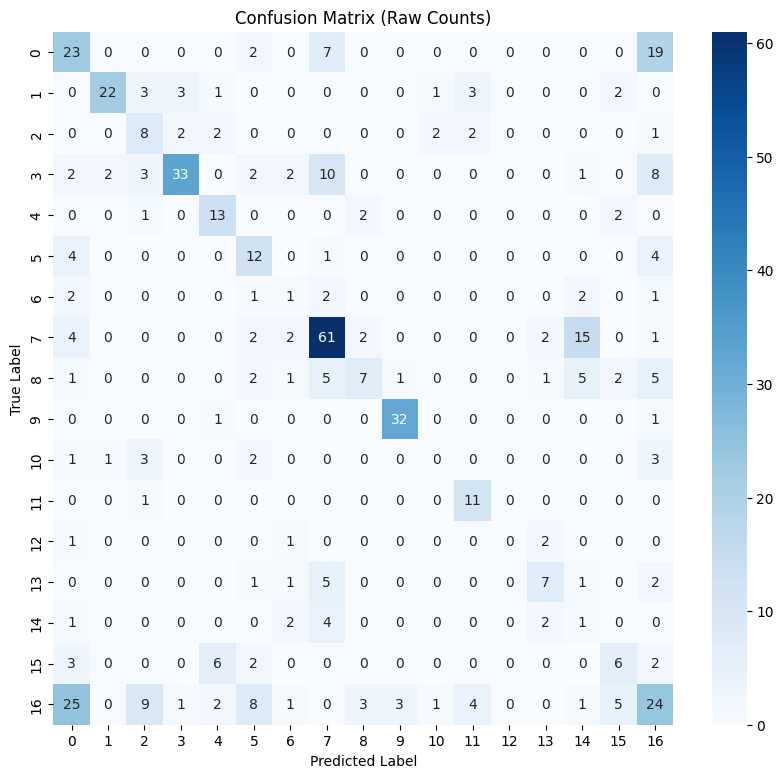

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 预测
y_pred = model_rf.predict(test_all_features)

# 分类报告
print("Classification Report:")
print(classification_report(test_all_labels, y_pred))

# 计算混淆矩阵（原始计数）
cm = confusion_matrix(test_all_labels, y_pred, labels=np.unique(test_all_labels))

plt.figure(figsize=(10, 9))

# 在 heatmap 中使用 cm (未归一化)，并将 fmt 设置成 'd' 显示整型
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            yticklabels=np.unique(test_all_labels),
            xticklabels=np.unique(test_all_labels))
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
